# Homework 4
## Part 2: Our first 2D FEM solver
$$
\newcommand{\dx}{\,\mathrm{d}x}
\newcommand{\ldb}{\left\llbracket}
\newcommand{\rdb}{\right\rrbracket}
\newcommand{\lp}{\left(}
\newcommand{\rp}{\right)}
\newcommand{\tn}{|\mspace{-1mu}|\mspace{-1mu}|}
\newcommand{\IR}{\mathbb{R}}
\newcommand{\dS}{\mathrm{d}S}
\newcommand{\ds}{\mathrm{d}s}
$$

### This is the solution of:
* Felix Svedberg
* Isac Östman
* Tor Djupman


The same general rules as for Homework 1 applies.

$\newcommand{\dx}{\,\mathrm{d}x}$ 
$\newcommand{\dy}{\,\mathrm{d}y}$
$\newcommand{\dS}{\,\mathrm{d}S}$
$\newcommand{\ds}{\,\mathrm{d}s}$

In [34]:
# Make plotted figures interactive
%matplotlib inline

Import relevant python modules and our own tiny helper modules.

In [35]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import meshtools as mt
import plottools as pt
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib import cm

## Your first own 2D FEM solver

The goal of this problem set is to build your first own finite element solver which will probably be a decisive step in your career :)

At the end of this problem we will be able to numerically solve
\begin{alignat}{3}
-\nabla \cdot ( a(x) \nabla u) &= f && \quad \text{in } \Omega 
\\
u &= g_D  && \quad \text{on } \partial \Omega_D
\\
n\cdot a \nabla u  &= \kappa(g_{R,D} - u) + g_{R,N} && \quad \text{on } \partial \Omega_R
\end{alignat}

Here, $n$ denotes the outward pointing normal vector on $\partial \Omega$.

Recall that the overall solution procedure works roughly like this:

##### 1) Preprocessing

You or somebody nice need to generate a suitable mesh $\{K_i\}_{i=0}^{n_t-1}$
consisting of $n_t$ elements and $n_p$ nodes $\{N_i\}_{i=0}^{n_p-1}$ 
for the given domain $\Omega$. These are usually given by the point matrix
$P$ and connectivity matrix $T$. (Here, the tiny meshgenerators module come into play).

##### 2) Finite Element Solver

Next you solve your PDE numerically. As discussed, the procedure looks roughly like
this

1.) Assemble the system matrix, irrespective of any Dirichlet boundary conditions,
defined by
$$
A_{ij} = \int_\Omega a(x)\nabla \phi_j \cdot \nabla \phi_i\dx + \int_{\partial\Omega_R}\kappa u v\dx \quad i,j = 0,\ldots n_p-1
$$
This matrix usually splits up into volume and boundary contribution
$$
A = A^{\Omega} + A^{\partial \Omega}
$$
Correspondingly, the assembly of $A$ is often split into

* 1a) an assembly of the volume contribution by running over all triangles $K$ 
* 1b) an assembly of the boundary contribution arising from natural (Robin) boundary conditions
by running over all relevant edges $E$

Here, $\{E\}_{i=1}^{n_{e}}$ is the boundary mesh coming from $\{K\}$.
Usually you have to mark the edges somehow to distinguish whether they belong to
$\partial \Omega_N$, $\partial \Omega_R$ (for the assembly of the natural boundary conditions imposed in the weak formulation) or  $\partial \Omega_D$ (for imposing Dirichlet boundary conditions in the function space).

2) Assemble the load vector $b$ defined by
$$
b_i = \int_\Omega f \phi_i \dx + \int_{\partial\Omega_N}(\kappa g_{R,D} + g_{R,N})\phi_i\ds \quad i = 0, \ldots, n_p-1.
$$
that is, irrespective of any Dirichlet boundary conditions.
Again this process can be split into an assembly of the volume and boundary contributions.

3) After you assembled the complete matrix system, you incorporate the 
Dirichlet boundary conditions on the nodes $\{N_i\}$ which are part of $\partial \Omega_D$. This amounts to replace 
row $i$ in the Matrix $A$ with the row vector $e_i = (0,\ldots,0, 1,0,\ldots,0)$
for each Dirichlet boundary node $N_i$. Correspondingly, in the load vector $b$
you replace the $i$-th row by $g_D(N_i)$, which leaves you with a modified matrice
$\widetilde{A}$ and a modified vector $\widetilde{b}$.

4) Finally, you solve the resulting matrix system
$$
\widetilde{A} U = \widetilde{b}
$$

##### Postprocessing

Often you want to do something with your computed solution, e.g. plot it, compute derived values such as the mean value $\tfrac{1}{|\Omega|}\int_{\Omega} u dx$ or the derivative $\nabla u$. Note this often is relatively easy compared to the finite difference method as you know your discrete solution everywhere thanks to the representation
$$
u_h(x) = \sum_{j=0}^{n_p-1} U_j \phi_j(x) \quad x \in \Omega
$$

Now let's get started with implementing our FEM solver.

## Step 1: Assembly of the stiffness matrix (volume contributions)

**a)** Start by implementing a first version of the  ```assemble_stiffness_matrix(P, T, a)``` which assemble the volume contributions corresponding to $\int_K a \nabla u \cdot \nabla v \dx$. 
Here, $P$ and $T$ are the point and connectivity matrices and $a(x)$ is the given coefficient.
Supplement the following code outline.

### Code Outline

First, we define a little helper functions which computes
for given triangle $K$ the area $|K|$. On $K$ we have three basis function $\lambda_i=a_i + b_ix + c_iy$ for $i=1,2,3$ with the cofficient vectors $b = (b_0, b_1, b_2)$ and $c = (c_0, c_1, c_2)$. Recall that gradients of the local shape/nodal functions
$\lambda_i$ are given by $\nabla \lambda_i = (b_i, c_i)^T$ for
$i = 0,1,2$.

Before you read through the helper functions convince yourself that the coefficient vectors $b$ and $c$ can be computed using the curl operator $\times$ as follows:
\begin{align*}
b = (y^{(0)},y^{(1)}, y^{(2)}) \times (1,1,1)
\\
c = (1,1,1)\times (x^{(0)},x^{(1)}, x^{(2)}) 
\end{align*}




In [36]:
def compute_hat_gradients(tri):
    # Compute area
    N0, N1, N2 = tri
    area=abs(0.5*np.cross(N1-N0, N2-N0))
    
    # Compute b = (1,1,1) x (x_2^1,x_2^2,x_2^3). c is similar
    ones = np.ones(3)
    b = np.cross(tri[:,1], ones)/(2*area)
    c = np.cross(ones, tri[:,0])/(2*area)

    return (area, b, c)

Now you are ready to define ```assemble_stiffness_matrix(P, T, a)```. Follow closely the implementation of the mass matrix assembly with only minor modifications.

In [37]:
def assemble_stiffness_matrix(P, T, a):
    # Create matrix as before
    # As in the mass matrix assembly:
    # Deduce number of unkowns from dimensions of P
    # number of elements from dimensions of T and sparse matrix A
    n_p = P.shape[0]
    n_t = T.shape[0]
    A = np.zeros((n_p, n_p))

    for  K in range(n_t):
        # Get local to global map
        loc2glo = T[K,:]
        # Get triangle coordinates and compute area
        tri = P[T[K,:]]
        N0 = tri[0]
        N1 = tri[1]
        N2 = tri[2]
        
        # Compute abar = a((N0 + N1 + N2)/3) to approximate \int_K a(x)dx
        abar = a((N0 + N1 + N2)/3)
        
        # Compute the area and the coefficient for the hat gradients
        area, b, c = compute_hat_gradients(tri)

        # Numpy Arrays does not behave exactly like n x 1 matrices
        # To compute the outer product b*b.T or  b*b' in Matlab notation
        # we need the np.outer function
        A_K = abar*(np.outer(b, b) + np.outer(c, c))*area
        
        # Add local element matrix to global matrix as before
        A[np.ix_(loc2glo, loc2glo)] += A_K

    return A

In [38]:
def assemble_load_vector(P, T, f, qr = "midpoint_2d"):
    """ Assembles the load vector """
    
    # Deduce number of unkowns from dimensions/shape of P
    n_p = P.shape[0]
    # Deduce number of elements from dimensions of T
    n_t = T.shape[0]
    
    
    # Create and intialize vector
    b = np.zeros(n_p)
    
    # Iterate over all triangles
    for  K in range(n_t):
        l2g = T[K]   # Get local to global map
        tri = P[T[K]]  # Get triangle coordinates and compute area
        N0,N1,N2 = tri 
        area = 0.5 * abs((N1[0] - N0[0])*(N2[1] - N0[1]) -
                        (N1[1] - N0[1])*(N2[0] - N0[0]))

        if qr == "midpoint_2d":   
            # 2d midpoint
            # three midpoint coordinates
            N01 = (N0 + N1)/2
            N12 = (N1 + N2)/2
            N20 = (N0 + N2)/2
            
            b_K = area/6*np.array([f(N01)+f(N20), f(N01)+f(N12), f(N12)+f(N20)])
        else:
            # 2d Trapezoid
            b_K = area/3*np.array([f(N0[0],N0[1]), f(N1[0],N1[1]), f(N2[0],N2[1])])
        # Add local contributions to the global load vector
        b[l2g] += b_K
        
    return b

**b**) As a first test run, let us use your new ```assemble_stiffness_matrix``` and the ```assemble_load_vector``` function previously implemented in Part 1 (that is only the volume contributions).
Assemble the stiffness matrix $A$ with coefficient $a(x) = 1$, load vector $b$ with 

$$f(x,y) = 1$$

on a simple unit square mesh with resolution $h = 1/N$ and $N = 20$.
Solve the resulting linear system $ AU = b$. 

* Discuss your result. It is helpful to check the rank of the matrix. Why is it so? 

*Hint*: Look into lab 2 for recalling how sparse linear systems are solved, don't forget to convert the assembled matrix A into the more efficient format *csr* before solving.

### Code Snippets

In [39]:
# Numpy way to define constant functions such that an
# array of constants is returned if x,y were arrays.
def f(x,y):
    return 1*np.ones_like(x)

/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_88881/16627033.py:4: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area=abs(0.5*np.cross(N1-N0, N2-N0))


Rank of Stiffness Matrix = 440
Dimension of Stiffness Matrix = 441


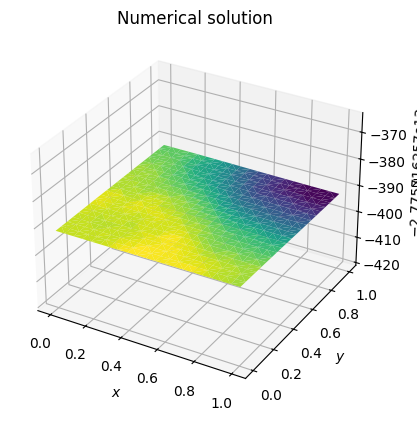

In [40]:
import numpy as np
N = 20

# Define mesh
P, T = mt.unitsquare_mesh(N)

a = lambda x: 1

A = assemble_stiffness_matrix(P, T, a)
b = assemble_load_vector(P, T, f, 0)

#calculate rank
rank = np.linalg.matrix_rank(A)
print(f"Rank of Stiffness Matrix = {rank}")
print(f"Dimension of Stiffness Matrix = {len(P)}")

#Translate matrix to csr
A_csr = csr_matrix(A)
U = spsolve(A_csr,b)

X = P[:,0]
Y = P[:,1]
pt.plot2D(X,Y,U,T,"Numerical solution")

__ANSWER 1b):__

The numerical solution is inaccurate. It is $\approx 0$, which is impossible when $f = 1$. Why is this? To answer that, it is useful to consider the rank of the stiffness matrix $A$. As we can see in the printed message above the figures, $rank(A) < dim(A)$ meaning that the we have a singular system. A singular system either has zero or infinite solutions, meaning that it is not strange that our numerical solution failed.

## Step 2: Incorporation of Dirichlet boundary conditions

**c**) Next, we start with implementing the incorporation of Dirchlet boundary conditions.

As a first step, implement a tiny function which checks
whether a given point $x = (x_0, x_1)$ is on the boundary of the unitsquare or not.
The function should return ```True``` if the point is on the boundary, otherwise return ```False```.

### Code Snippet

In [41]:
def on_dirichlet_boundary(x):
    eps = 1e-12 # Accounts for finite precision
    return  (x[0] < eps or x[0] > 1 - eps or x[1] < eps or x[1] > 1 - eps)

With such a function a place, one can extract the boundary point using the following code snippet which returns a list of all node indices $i$ of those nodes $N_i$ for which a given function ```inside_domain(N_i)``` evaluates to ```True```.

In [42]:
def extract_nodes(P, inside_domain):
    return [ i for i in range(P.shape[0]) if inside_domain(P[i]) ]

Now define unitsquare meshes with 1, 2 and 3 subdivision in each direction and 
check whether you extract all Dirichlet boundary nodes correctly by
using the improved $\texttt{plot_mesh_2d}$ function now residing in the $\texttt{plottools}$ module. Use the new optional 3 function argument "dirichlet_nodes" in $\texttt{plot_mesh_2d}$ to plot the extracted nodes.

[0, 1, 2, 3]


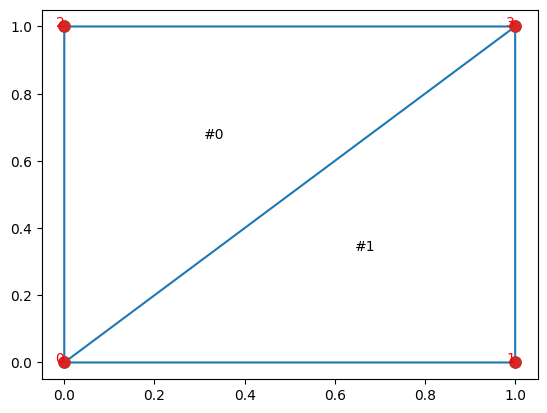

[0, 1, 2, 3, 5, 6, 7, 8]


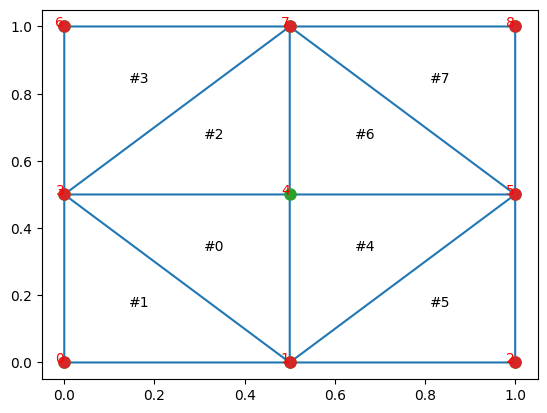

[0, 1, 2, 3, 4, 7, 8, 11, 12, 13, 14, 15]


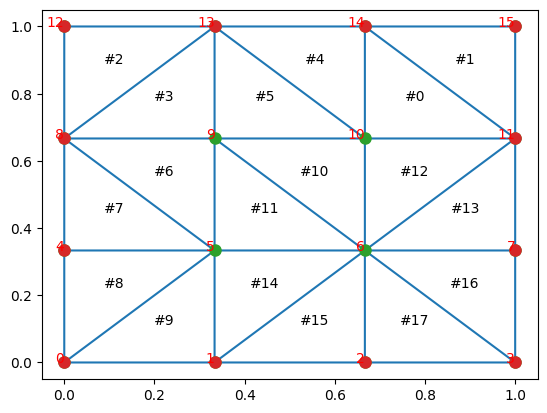

In [43]:
# Generat a mesh
for N in range (1,4):
    P, T = mt.unitsquare_mesh(N)
    # Extract mesh coordinates
    X = P[:,0]
    Y = P[:,1]
    dirichlet_nodes = extract_nodes(P, on_dirichlet_boundary)
    print(dirichlet_nodes)
    pt.plot_mesh_2d(P, T, dirichlet_nodes)

**d**) Next you need a piece of code to evaluate boundary functions at the nodes you extracted and to incorporate these values into the matrix $A$ and $b$.

Make sure that you understand the code snippets.

### Code Snippets 

Incorporation of Dirichlet BC.

In [44]:
def apply_bcs(A, b, dirichlet_nodes, g_D_values):
    # Incorporate boundary condition in vector b
    # by slicing out entries of b associated with dirichlet nodes
    # and setting them to the corresponding value
    b[dirichlet_nodes] = g_D_values

    # Incorporate boundary conditions in matrix A
    # 1. Set all rows corresponding to Dirichlet nodes to 0
    A[dirichlet_nodes, :] = 0 
    
    # 2. Set diagonal in Dirichlet nodes to one 
    # (Opposed to Matlab this code line practically
    # extracts a part of the diagonal corresponding to passes indices in  
    # dirichlet_nodes and set them to 1
    A[dirichlet_nodes, dirichlet_nodes] = 1
    return A, b

**e**) Next, do a first check of the correctness of your implementation by solving

\begin{alignat*}{3}
-\Delta u &= 0 && \quad \text{in } \Omega \\
 u(x,y) &= x + y &&\quad \text{on } \partial \Omega
\end{alignat*}

and plotting $u$, $u_h$ and their difference. 

What is the exact solution $u$? And how does the finite element solution $u_h$ and the error look like?


__ANSWER 2e)__

The exact solution is 
\begin{align}
    u(x,y) = x + y,
\end{align}
which can veryfied by applying 
\begin{align}
    \frac{\partial^{2}}{\partial x^{2}} + \frac{\partial^{2}}{\partial x^{2}}
\end{align} to $u$.

In [45]:
# Numpy way to define constant functions such that an
# array of constants is returned if x,y were arrays.
def f(x,y):
    return 0*np.ones_like(x)

/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_88881/16627033.py:4: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area=abs(0.5*np.cross(N1-N0, N2-N0))


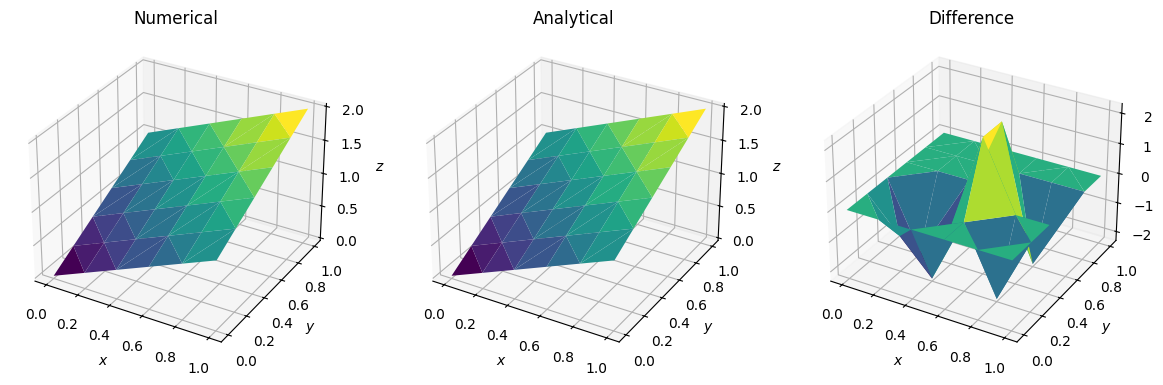

In [46]:
N = 5

#Analytical solution
u_anal = lambda x,y : x+y

# Define mesh
P, T = mt.unitsquare_mesh(N)
X = P[:,0]
Y = P[:,1]

#Coefficent a(x)
a = lambda x: 1

#Dirichlet BC
g_D = lambda x,y : x+y

A = assemble_stiffness_matrix(P, T, a)
b = assemble_load_vector(P, T, f, 0)


# Define/use your on_dirichlet_boundary and extract_nodes functions
# to compute the dirichlet nodes
dirichlet_nodes = extract_nodes(P,on_dirichlet_boundary)

# Extract coordinates associated with Dirichlet nodes 
# using an array slicing operation
X_dc = X[dirichlet_nodes]
Y_dc = Y[dirichlet_nodes]

# Evaluate g at boundary nodes and 
g_D_values = g_D(X_dc, Y_dc)

#Apply boundary condition to load vector and stiffnes matrix.
A, b = apply_bcs(A,b, dirichlet_nodes, g_D_values)

A_csr = csr_matrix(A)
U = spsolve(A_csr,b)
pt.plot_comparison_2D(X,Y,U,u_anal(X,Y),T,"Numerical","Analytical")

**f**) Next, solve the problem
\begin{alignat*}{3}
-\Delta u &= 1 && \quad \text{in } \Omega \\
 u &= 0 &&\quad \text{on } \partial \Omega.
\end{alignat*}
on unit square meshes with mesh size $h=1/N$ for $N = 5, 40$
and plot the FEM solution. 

In [47]:
# Numpy way to define constant functions such that an
# array of constants is returned if x,y were arrays.
def f(x,y):
    return 1*np.ones_like(x)

/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_88881/16627033.py:4: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area=abs(0.5*np.cross(N1-N0, N2-N0))


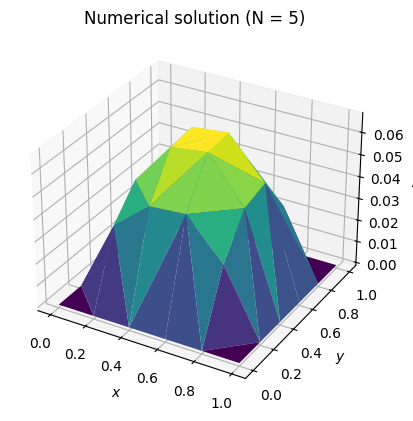

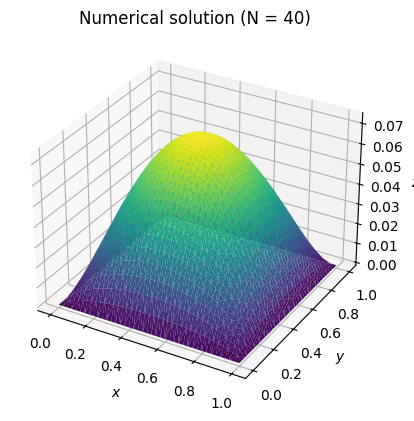

In [48]:
for N in [5,40]:
    
    
    #Analytical solution
    #u_anal = lambda x,y : x+y
    
    # Define mesh
    P, T = mt.unitsquare_mesh(N)
    
    #Get x and y coordinates
    X = P[:,0]
    Y = P[:,1]
    
    #Coefficent a(x)
    a = lambda x: 1
    
    #Dirichlet BC
    g_D = lambda x,y : 0
    
    A = assemble_stiffness_matrix(P, T, a)
    b = assemble_load_vector(P, T, f, 0)
    
    
    # Define/use your on_dirichlet_boundary and extract_nodes functions
    # to compute the dirichlet nodes
    dirichlet_nodes = extract_nodes(P,on_dirichlet_boundary)
    
    # Extract coordinates associated with Dirichlet nodes 
    # using an array slicing operation
    X_dc = X[dirichlet_nodes]
    Y_dc = Y[dirichlet_nodes]
    
    # Evaluate g at boundary nodes and 
    g_D_values = g_D(X_dc, Y_dc)
    
    #Apply boundary condition to load vector and stiffnes matrix.
    A, b = apply_bcs(A,b, dirichlet_nodes, g_D_values)
    
    A_csr = csr_matrix(A)
    U = spsolve(A_csr,b)
    pt.plot2D(X,Y,U,T,f"Numerical solution (N = {N})")

**g**) Repeat the experiment, this time for the boundary value problem 
\begin{alignat*}{3}
-\Delta u &= 1 && \quad \text{in } \Omega \\
 u &= 0 &&\quad \text{on } \partial \Omega_D,
 \\
 \nabla u \cdot n &= 0 &&\quad \text{on } \partial \Omega_N,
\end{alignat*}
where $\partial \Omega_N = \{1\} \times [0,1]$ is right edge of the the unit square
and $\partial \Omega_D = \partial \Omega \setminus \partial \Omega_N$.

How can you interpret the Neuman condition $\nabla u \cdot n = 0$ on $\partial \Omega_N$ geometrically? 

__ANSWER 2g)__

Geometrically
\begin{align}
    \nabla u \cdot n = 0,
\end{align}
means that the solution takes on a constant value outside the boundary, along the boundary's normal. It does not change in this direction.  Think of $u$ as describing the temperature in a rod. Inside the rod the temperature might change, but outside of it the temperature takes on a constant value equal to the one at the boundary (unrealistic example but you get the idea).


In [49]:
def on_dirichlet_boundary(x):
    eps = 1e-12 # Accounts for finite precision
    #Boundary dirichlet for every boundary except right edge
    return  (x[0] < eps or x[1] < eps or x[1] > 1 - eps)

In [50]:
def homog_neumann_boundary(x):
    eps = 1e-12 # Accounts for finite precision
    return  (abs(x[0]-1) < eps and x[1] > -eps and x[1] < 1 + eps)

/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_88881/16627033.py:4: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area=abs(0.5*np.cross(N1-N0, N2-N0))


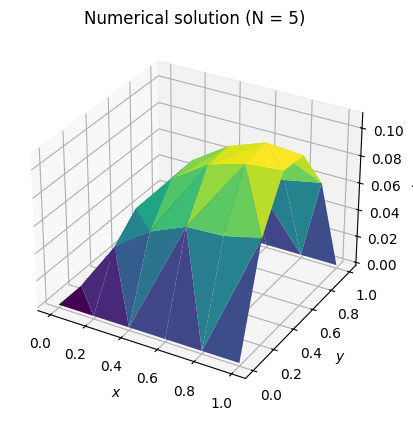

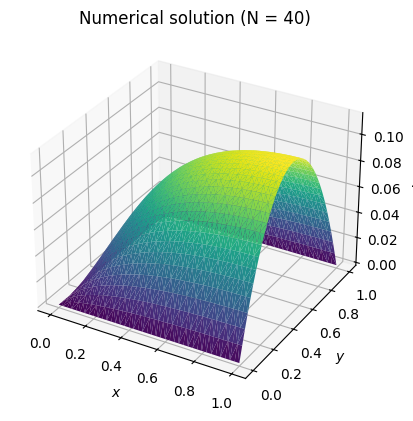

In [51]:
for N in [5,40]:
    
    
    #Analytical solution
    #u_anal = lambda x,y : x+y
    
    # Define mesh
    P, T = mt.unitsquare_mesh(N)
    
    #Get x and y coordinates
    X = P[:,0]
    Y = P[:,1]
    
    #Coefficent a(x)
    a = lambda x: 1
    
    #Dirichlet BC
    g_D = lambda x,y : 0

    #Neumann BC
    g_N = lambda x,y : 0
    
   
    
    
    # Define/use your on_dirichlet_boundary and extract_nodes functions
    # to compute the dirichlet nodes
    dirichlet_nodes = extract_nodes(P,on_dirichlet_boundary)
    E_N = extract_edges(P,T,homog_neumann_boundary)

    A = assemble_stiffness_matrix(P, T, a)
    b = assemble_load_vector_neu(P, T, f, E_N, g_N, 0)
    
    # Extract coordinates associated with Dirichlet nodes 
    # using an array slicing operation
    X_dc = X[dirichlet_nodes]
    Y_dc = Y[dirichlet_nodes]

    
    # Evaluate g at boundary nodes and 
    g_D_values = g_D(X_dc, Y_dc)
    
    #Apply boundary condition to load vector and stiffnes matrix.
    A, b = apply_bcs(A,b, dirichlet_nodes, g_D_values)
    
    #MUST APPLY NEUMANN CONTRIBUTION TO b SOMEHOW
    
    A_csr = csr_matrix(A)
    U = spsolve(A_csr,b)
    #
    pt.plot2D(X,Y,U,T,f"Numerical solution (N = {N})")

## Step 3: Incorporation of inhomogeneous Neumann boundary conditions

**h**) The next task is to incorporate inhomogeneous Neumann conditions
\begin{align*}
\nabla u \cdot n &= g_N \quad \text{on } \partial \Omega_N
\end{align*}
for some $g_N \neq 0$. Thus to obtain the load vector $b$, you now need to compute integrals of the form   
\begin{align*}
\int_{\Omega} f \varphi_i
\dx + \int_{\partial \Omega_N} g_N \varphi_i \quad i = 0,\ldots,n_p-1.
\end{align*}

To do so, you have to do accomplish 2 things:

1. Similar to extracting the Dirichlet nodes to impose Dirichlet boundary conditions, you need
now to extract the Neumann boundary edges $\mathcal{E}_{h,N}$ of $\mathcal{K}_h$ which comprises the boundary $\partial 
\Omega_N$. At the end of the day you want to have $n_e\times 2$  "Edge" connectivity matrix $E_N$ 
(similar to the triangle connectivity matrix $T$), where $n_e$ is the number of extracted boundary
edges. Column $j$ in the "Edge" connectivity matrix $E_N$ then gives the the two  indices of the nodes defining the
boundary edge $E_j$. Note that the set of extracted boundary edges is only a *subset* of the set of *all* edges in $\mathcal{K}_h$.
2. Next, in addition to the previous arguments ```T, P, f```, you need to pass $E_N$ and $g_N$ to your ```assemble_load_vectorc function and add a loop which assembles the contribution
$\int_{E} g_N \varphi_i \dS$ from
the boundary $\partial \Omega_N$ by iterating over $\mathcal{E}_{h,N}$. This is **very** similar to
what you did to compute the volume contribution $\int_{K} f \varphi_i \dx$.
As a proper quadrature rule to assemble $\int_{E} g_N \varphi_i \dS$, simply apply the 1-d trapezoidal rule to the 1d edge $E$ and integrand $g_N \varphi_i$. Convince yourself that the resulting local/edge load vector contribution looks like
\begin{align*}
b_E = \dfrac{|E|}{2} 
\begin{bmatrix}
g_N(N_0) , g_N(N_1)    
\end{bmatrix}^T
\end{align*}
where $N_0$ and $N_1$ are the two nodes (in local numbering) belonging to edge $E$. 


### Code Snippets

Make sure that you understand the following code snippet)

In [52]:
def extract_edges(P, T, inside_domain):
    """Short function which extract all edge indices i
    for which the inside_domain(P[i]) evaluates to True
    for both edge vertices.
    """
    edges = []
    for t in T:
        # Iterate over edges
        for i in range(3):
            # Check whether end points of edges are inside domain
            # Note that we use the index notation t[-1] to access the last node
            if inside_domain(P[t[i-1]]) and inside_domain(P[t[i]]):
                if abs(P[t[i-1],0]-P[t[i],0])<1e-12 or abs(P[t[i-1],1]-P[t[i],1])<1e-12:
                    edges.append([t[i-1], t[i]])
    # Return the edge list as numpy array to treat it similar
    # to T. Note that we have to explicitly tell the array constructor
    # that the element of the array should be treat as integers!
    # Otherwise you will get indexing problems later on.
    return np.array(edges, dtype=np.int32)

Now you need to define proper ```inside_domain``` function, similiar to you ```on_dirichlet_boundary``` function, e.g.

In [53]:
def inhomog_neumann_boundary(x):
    eps = 1e-12 # Accounts for finite precision
    return  (abs(x[0]) < eps and x[1] > -eps and x[1] < 1 + eps)

In [54]:
def on_dirichlet_boundary(x):
    eps = 1e-12 # Accounts for finite precision
    return  (x[0] > 1 - eps or x[1] < eps or x[1] > 1 - eps)

In [55]:
def assemble_load_vector_neu(P, T, f, E, g_N, qr = "midpoint_2d"):
    """ Assembles the load vector """
    
    # Deduce number of unkowns from dimensions/shape of P
    n_p = P.shape[0]
    # Deduce number of elements from dimensions of T
    n_t = T.shape[0]
    #Deduce number of neumann edges
    n_Ne = E.shape[0]
    
    # Create and intialize vector
    b = np.zeros(n_p)
    
    # Iterate over all triangles
    for  K in range(n_t):
        l2g = T[K]   # Get local to global map
        tri = P[T[K]]  # Get triangle coordinates and compute area
        N0,N1,N2 = tri 
        area = 0.5 * abs((N1[0] - N0[0])*(N2[1] - N0[1]) -
                        (N1[1] - N0[1])*(N2[0] - N0[0]))

        if qr == "midpoint_2d":   
            # 2d midpoint
            # three midpoint coordinates
            N01 = (N0 + N1)/2
            N12 = (N1 + N2)/2
            N20 = (N0 + N2)/2
            
            b_K = area/6*np.array([f(N01)+f(N20), f(N01)+f(N12), f(N12)+f(N20)])
        else:
            # 2d Trapezoid
            b_K = area/3*np.array([f(N0[0],N0[1]), f(N1[0],N1[1]), f(N2[0],N2[1])])
        # Add local contributions to the global load vector
        b[l2g] += b_K

    for e in range(n_Ne):
        l2g = E[e]
        N0 = P[l2g[0]] #get node coordinates
        N1 = P[l2g[1]]
        edge_len = np.sqrt((N0[0]-N1[0])**2+(N0[1]-N1[1])**2)
        b_Ne = 0.5*edge_len*np.array([g_N(N0[0],N0[1]), g_N(N1[0],N1[1])])
        b[l2g] += b_Ne 
    return b

In [56]:
def f(x,y):
    return(2*np.pi**2*np.sin(np.pi*x)*np.cos(np.pi*y))

Note that the ```plot_mesh_2d``` function can visualize a set of edges if you pass one, this is
very useful to visually check whether your ```inhomog_neumann_boundary``` does what you expect!

**i**) 
Next, to appreciate your craftsmanship, validate your new functionality using the method
of manufactured solutions. Start from the exact solution
$$
u(x,y) = \sin(\pi x) \cos(\pi y)
$$
to construct a manufactured solution for the boundary value problem
\begin{alignat*}{3}
-\Delta u &= f && \quad \text{in } \Omega \\
 u &= g_D &&\quad \text{on } \partial \Omega_D,
 \\
 \nabla u \cdot n &= g_N &&\quad \text{on } \partial \Omega_N,
\end{alignat*}
by computing the proper problem data $f$, $g_D$ and $g_N$. Here,
$\partial \Omega_N = \{0\} \times[0,1]$ is the left edge of the unit
square and
$\partial \Omega_D = \partial \Omega \setminus \partial \Omega_N$.

Proceed as follows:

* with the computed problem data $f$, $g_D$ and $g_N$ at hand, solve the given boundary value problem  numerically using your finite element solver on unit square meshes with mesh size $h=1/N$ for $N = 5, 10, 20, 40$;
* plot the exact solution $u$, the finite element solution $u_h$ and the error function $u - u_h$
for $N = 5, 20, 40$;
* compute analytically the integral
$ \tn  u \tn^2 = \| \nabla u \|_{L^2(\Omega)}^2 = \int_{\Omega} |\nabla u |^2\dx$
Hint: it boils down to the computation of some 1D integrals.
* compute for $N = 5, 10, 20, 40$ the discretization error and resulting experimental order of convergence (EOC) based on the formula
$\tn u - u_h \tn^2 \approx \tn u \tn^2 - \tn u_h \tn^2$ previously employed in Lab 3. Why does this formula not hold exactly? Note that the matrix used to compute $\tn u_h \tn^2 = \xi^TA_h\xi$ should not have the Dirichlet boundary conditions implemented. 

Hint: do you think A will be changed after calling the function ```apply_bcs```? If you are not sure, write a similar test function to find out. Hopefully you will see that, you need to make minor modifications to ```apply_bcs``` for computing the error in the energy norm. 

__ANSWER 3 i):__


From 
\begin{align}
    u(x,y) = \sin(\pi x)\cos(\pi y)
\end{align}

we have that 
\begin{align}
    -\Delta u = f(x,y) = 2\pi^{2}\sin(\pi x)\cos(\pi y)
\end{align}. 

Since our Neumann boundary is the left edge of the unit square, its normal is
\begin{align}
    u = (-1,0)
\end{align}
which in turn means that
\begin{align}
    &\nabla u \cdot n = (\pi\cos(\pi x)\cos(\pi y), -\sin(\pi x)\sin(\pi y)) \cdot (-1,0) \\
    & =  -\pi\cos(\pi x)\cos(\pi y)
\end{align}




/var/folders/y0/3xglwysx2hnc0mrw17d9bzb40000gp/T/ipykernel_88881/16627033.py:4: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area=abs(0.5*np.cross(N1-N0, N2-N0))


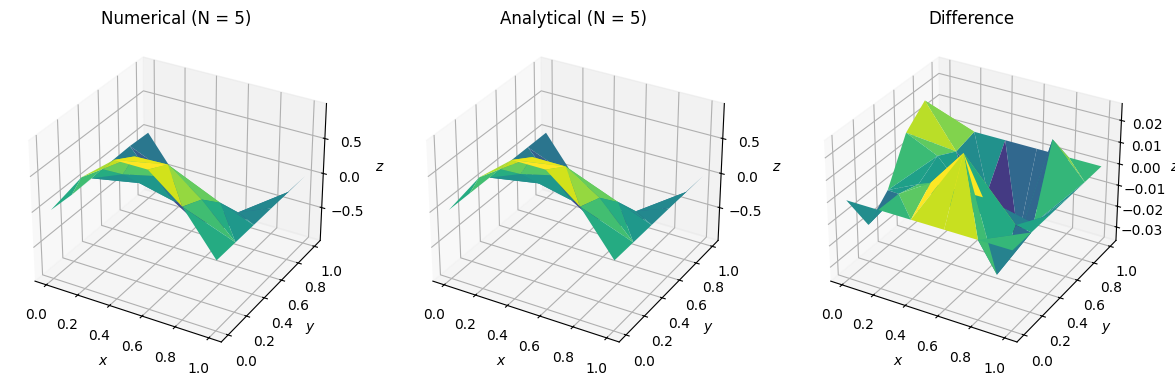

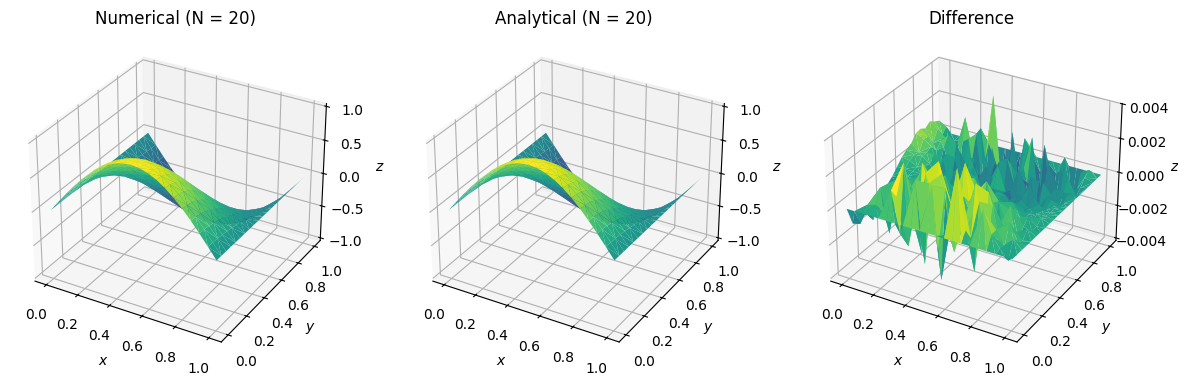

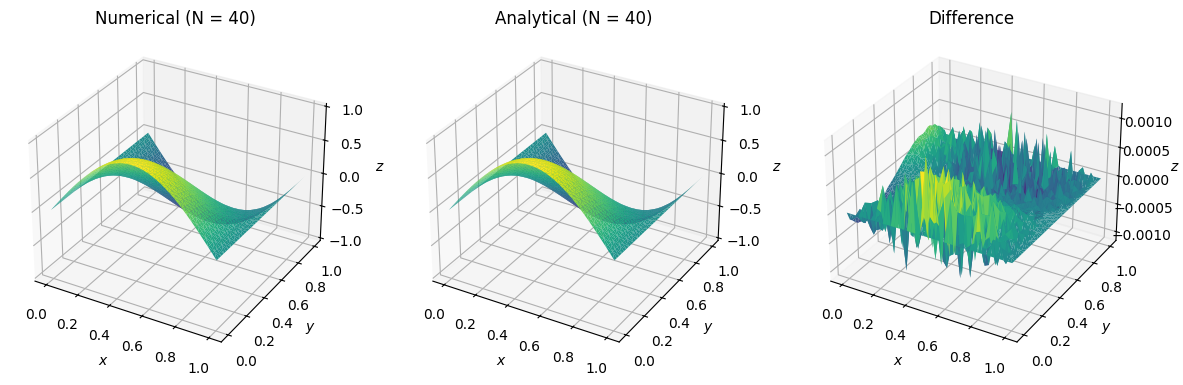

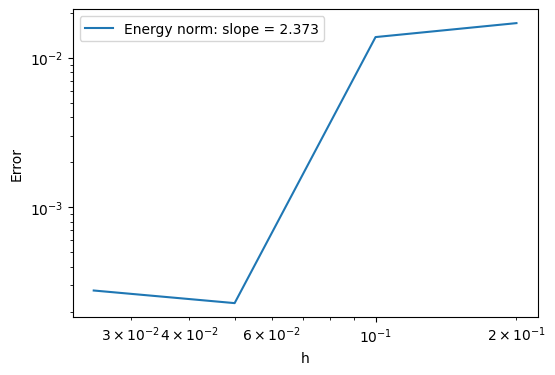

In [57]:
#3i)

N_values = [5,10,20,40]
h = [1/5, 1/10, 1/20, 1/40]
discr_error = np.zeros(4)


for i,N in enumerate(N_values):

    #Generate mesh
    P,T = mt.unitsquare_mesh(N)
    #Exract nodes on dirichlet
    dirichlet_nodes = extract_nodes(P,on_dirichlet_boundary)
    #Extract edges that makes up neumann boundary
    E_N = extract_edges(P,T, inhomog_neumann_boundary)
    
        
    
    
    #Get x and y coordinates
    X = P[:,0]
    Y = P[:,1]
    
    #Coefficent a(x)
    a = lambda x: 1
    
    #Dirichlet BC
    g_D = lambda x,y : np.sin(np.pi*x)*np.cos(np.pi*y)
    
    #Neumann BC
    g_N = lambda x,y : -np.pi*np.cos(np.pi*x)*np.cos(np.pi*y)
    
    A = assemble_stiffness_matrix(P, T, a)
    b = assemble_load_vector_neu(P, T, f, E_N, g_N,  0)
    
    
    # Define/use your on_dirichlet_boundary and extract_nodes functions
    # to compute the dirichlet nodes
    dirichlet_nodes = extract_nodes(P,on_dirichlet_boundary)
    
    # Extract coordinates associated with Dirichlet nodes 
    # using an array slicing operation
    X_dc = X[dirichlet_nodes]
    Y_dc = Y[dirichlet_nodes]
    
    
    # Evaluate g at boundary nodes and 
    g_D_values = g_D(X_dc, Y_dc)

    # Save to compute E-norm later
    A_no_bc = A.copy()
    
    #Apply boundary condition to load vector and stiffnes matrix.
    A, b = apply_bcs(A,b, dirichlet_nodes, g_D_values)
    
  
    
    A_csr = csr_matrix(A)
    U = spsolve(A_csr,b)

    discr_error[i] = np.abs(0.5*(np.pi*np.pi) - U.T @ A_no_bc @ U) 
     
    #Analytical function
    U_anal = lambda x,y: np.sin(np.pi*x)*np.cos(np.pi*y)
    #Solve analytical on grid
    Sol_anal = U_anal(X,Y);
    #
    if N != 10: 
        pt.plot_comparison_2D(X,Y,U,Sol_anal,T,f"Numerical (N = {N})",f"Analytical (N = {N})")

slope_eoc = np.polyfit(np.log(h), np.log(discr_error), 1)[0]

plt.figure(figsize=[6,4])
plt.loglog(h,discr_error)
plt.xlabel("h")
plt.ylabel("Error")
plt.legend([f"Energy norm: slope = {slope_eoc:.03f}"])

plt.show()

__ANSWER 3 i) cont:___

The EOC was calculated by interpolation to be 2.373. The formula is not exact since the Galerkin orthogonality is only approximate after discretization.  
